# Min and Max Temperatures

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.insert(0, "..")
from helpers.aws import execute_athena_query

sns.set_theme()

sql = f"""
select
  min(temperature) as min_temp,
  max(temperature) as max_temp,
  avg(temperature) as mean_temp,
  month
from (
        select
            temperature,
            date_trunc('month', observation_ts) as month
        from incoming.weather
        where year <> '2022' and month <> '7' and site_name <> 'CHIVENOR' or temperature > -5 -- exclude broken readings from Chivenor
    )
group by month
order by month
"""

results_url = execute_athena_query(sql, "lake", "dantelore.queryresults")
df = pd.read_csv(results_url)
df['month'] = pd.to_datetime(df['month']).dt.strftime('%B %Y')
df["mean_temp"] = df["mean_temp"].round(1)
df

,min_temp,max_temp,mean_temp,month


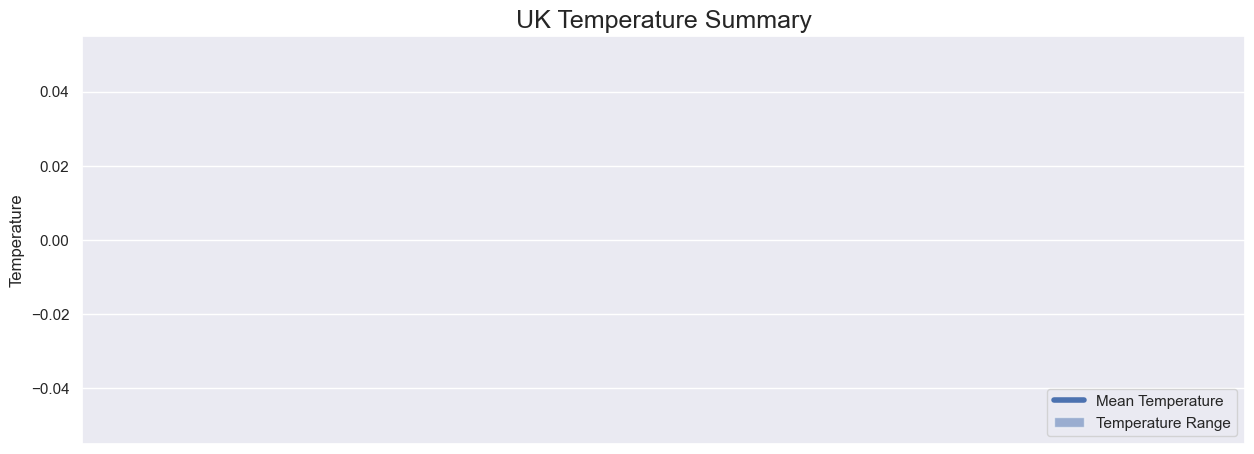

In [12]:
f, ax = plt.subplots(figsize=(15, 6))
ax.set_title('UK Temperature Summary', fontdict={'fontsize': '18', 'fontweight' : '3'})

# Ensure numeric types for plotting
df['min_temp'] = pd.to_numeric(df['min_temp'], errors='coerce')
df['max_temp'] = pd.to_numeric(df['max_temp'], errors='coerce')
df['mean_temp'] = pd.to_numeric(df['mean_temp'], errors='coerce')

ax.plot(df.index, df['mean_temp'], linewidth=4.0, label="Mean Temperature")
ax.fill_between(df.index, df['min_temp'], df['max_temp'], alpha=0.5, label="Temperature Range")

plt.gcf().autofmt_xdate()

plt.xlabel('')
plt.ylabel('Temperature', fontsize=12)
plt.legend(loc='lower right')
plt.xticks(df.index, df["month"].values)
plt.show()

In [13]:
sql = f"""
select site_id, site_name, observation_ts, temperature, lat, lon 
from weather 
where year = 2022 and month = 7 
order by temperature asc 
limit 3
"""

results_url = execute_athena_query(sql, "lake", "dantelore.queryresults")
cold_places = pd.read_csv(results_url)
cold_places

,site_id,site_name,observation_ts,temperature,lat,lon


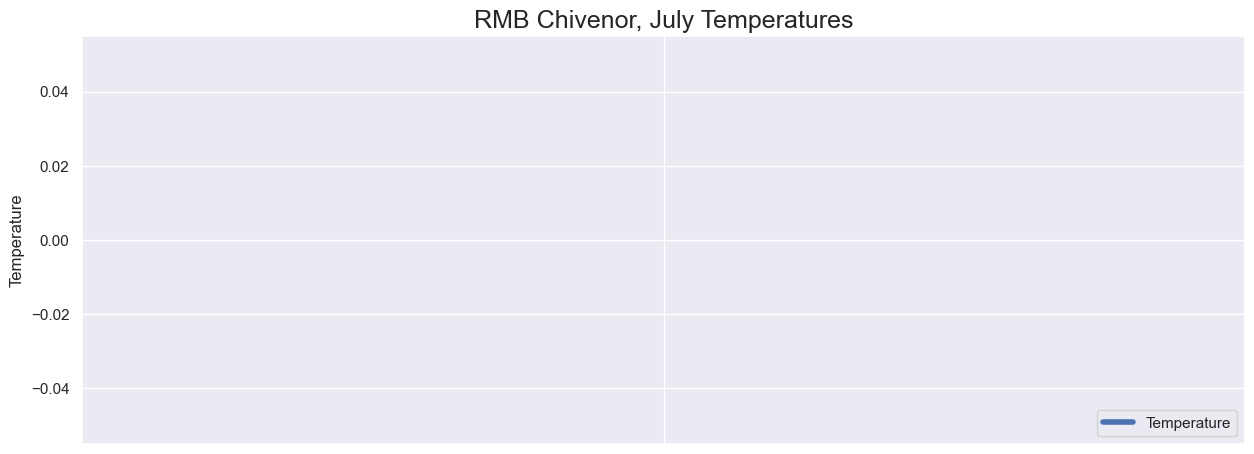

In [14]:
sql = f"""
select observation_ts, temperature 
from weather 
where year = 2022 and month = 7
  and observation_ts between TIMESTAMP '2022-07-03 00:00:00' and TIMESTAMP '2022-07-10 00:00:00' 
  and site_id = '3707' 
order by observation_ts asc
"""

results_url = execute_athena_query(sql, "lake", "dantelore.queryresults")
chivenor_july = pd.read_csv(results_url)


chivenor_july['xlabel'] = pd.to_datetime(chivenor_july['observation_ts']).dt.strftime('%d %B %H:%m')

f, ax = plt.subplots(figsize=(15, 6))
ax.set_title('RMB Chivenor, July Temperatures', fontdict={'fontsize': '18', 'fontweight' : '3'})

ax.plot(chivenor_july.index, chivenor_july.temperature, linewidth=4.0, label="Temperature")

plt.gcf().autofmt_xdate()

plt.xlabel('')
plt.ylabel('Temperature', fontsize=12)
plt.legend(loc='lower right')
plt.xticks(chivenor_july.index, chivenor_july["xlabel"].values)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(6))
plt.show()

# Finding Duplciates

## Duplicates by Partition

In [15]:
sql = f"""
select
  count(*) as num_rows,
  cast(year as int) as year,
  cast(month as int) as month
from weather
group by year, month
order by num_rows desc
"""

results_url = execute_athena_query(sql, "lake", "dantelore.queryresults")
df1 = pd.read_csv(results_url)

df1.head(10)


,num_rows,year,month


## Duplicates by Event Time

In [16]:

sql = f"""
select
    obs_period,
    count(*) as num_rows from
    (
        select
          *,
          date_trunc('day', observation_ts) as obs_period
          from weather
    )
group by obs_period
order by num_rows desc
"""

results_url = execute_athena_query(sql, "lake", "dantelore.queryresults")
df2 = pd.read_csv(results_url)
df2.head(10)

,obs_period,num_rows


## Distribution of row counts

Clearly most days have the 'right' number of rows, but there are a few outliers with too many or too few.

See below cumulative distribution (ECFD) and Kernel density estimation (KDE) for the number of rows vs days.

C:\Users\dan\AppData\Local\Temp\ipykernel_8488\3582254018.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df2, ax=axes[0], x="num_rows", cut=0, fill=True)


<Axes: title={'center': 'ECFD Plot'}, xlabel='num_rows', ylabel='Proportion'>

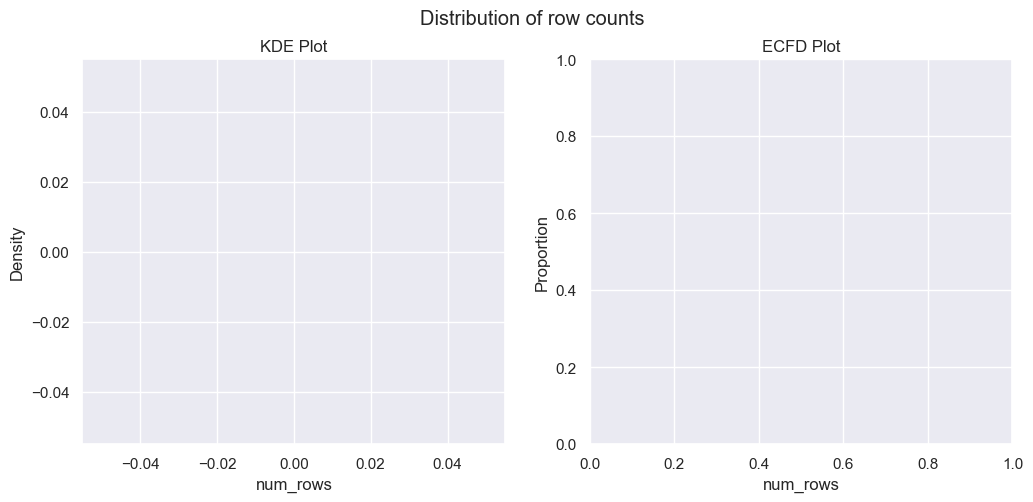

In [17]:
figure, axes = plt.subplots(1, 2, figsize=(12,5))
figure.suptitle('Distribution of row counts')
axes[0].set_title('KDE Plot')
axes[1].set_title('ECFD Plot')

sns.kdeplot(df2, ax=axes[0], x="num_rows", cut=0, fill=True)
sns.ecdfplot(df1, ax=axes[1], x="num_rows")

## Deduplication

In [18]:
sql = f"""
select
    obs_period,
    count(*) as num_rows
from
(
    select
        *,
        date_trunc('day', observation_ts) as obs_period,
        ROW_NUMBER() OVER ( partition by date_trunc('hour', observation_ts), site_id order by observation_ts desc ) as rn
       from weather
)
where rn = 1
group by obs_period
order by num_rows desc
"""

results_url = execute_athena_query(sql, "lake", "dantelore.queryresults")
deduped_df = pd.read_csv(results_url)
deduped_df.head(5)

,obs_period,num_rows


C:\Users\dan\AppData\Local\Temp\ipykernel_8488\3952875777.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(deduped_df, ax=axes[0], x="num_rows", cut=0, fill=True)
C:\Users\dan\AppData\Local\Temp\ipykernel_8488\3952875777.py:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df1, ax=axes[0], x="num_rows", cut=0, fill=True)


<Axes: title={'center': 'ECFD Plot'}, xlabel='num_rows', ylabel='Proportion'>

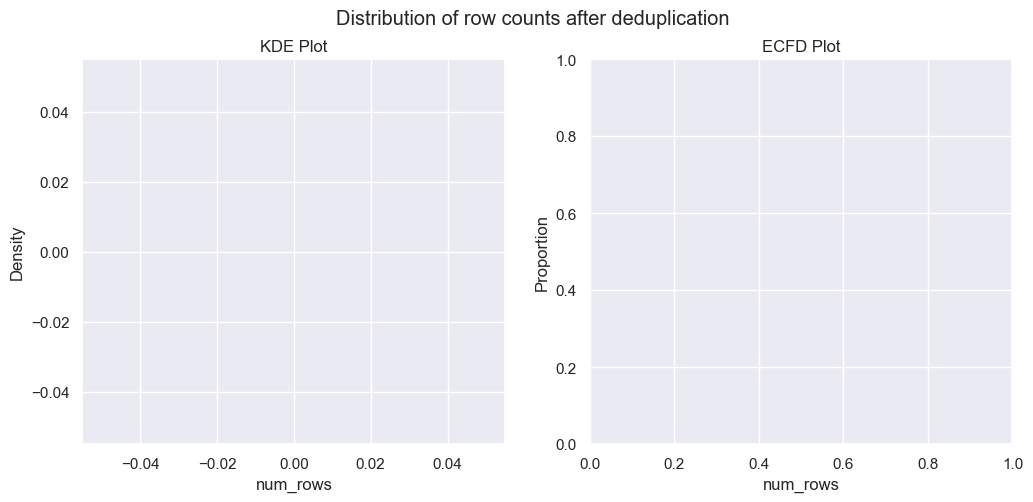

In [19]:
figure, axes = plt.subplots(1, 2, figsize=(12,5))
figure.suptitle('Distribution of row counts after deduplication')
axes[0].set_title('KDE Plot')
axes[1].set_title('ECFD Plot')

sns.kdeplot(deduped_df, ax=axes[0], x="num_rows", cut=0, fill=True)
sns.kdeplot(df1, ax=axes[0], x="num_rows", cut=0, fill=True)
sns.ecdfplot(deduped_df, ax=axes[1], x="num_rows")
sns.ecdfplot(df1, ax=axes[1], x="num_rows")

### Days with less than 90% of expected rows

In [20]:
highest = deduped_df.num_rows.max() # Somewhat lazy way to get the max possible number of measurements in a day - doesn't account for sites added and removed over time etc
low_cutoff = round(highest * 0.90)

low_days = deduped_df[deduped_df.num_rows < low_cutoff].sort_values(by=['num_rows'])
low_days["percentage"] = round(low_days["num_rows"] * 100 / highest)

print(f"Max value: {highest} Cutoff @ 90%: {low_cutoff} Number of days below cutoff: {len(low_days)} which is {round(len(low_days) * 100 / len(df2), 2)}% of the total")

low_days

ValueError: cannot convert float NaN to integer

### Days with duplicated data

In [ ]:
high_cutoff = highest
high_days = df2[df2.num_rows > high_cutoff].sort_values(by=['num_rows'], ascending=False)
print(f"Number of days above max: {len(high_days)} which is {round(len(high_days) * 100 / len(df2), 2)}% of the total")

high_days["percentage"] = round(high_days["num_rows"] * 100 / highest)

high_days

Number of days above max: 284 which is 80.0% of the total


,obs_period,num_rows,percentage
0,2021-12-13 00:00:00.000,6199,184.0
1,2022-01-05 00:00:00.000,5278,157.0
2,2022-10-19 00:00:00.000,4839,144.0
3,2022-11-26 00:00:00.000,3664,109.0
4,2022-01-21 00:00:00.000,3500,104.0
...,...,...,...
279,2022-10-21 00:00:00.000,3363,100.0
280,2022-10-27 00:00:00.000,3361,100.0
281,2022-10-17 00:00:00.000,3361,100.0
282,2022-08-23 00:00:00.000,3361,100.0
